In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
from collections import defaultdict, Counter
from scipy.stats import linregress
import random
from utils import transform_csgo_to_panda3d

random.seed(42)
np.random.seed(42)


In [2]:
def load_trajectories(max_trajectories=None, do_transform=True):
    player_data_path = Path('data/player_seq_allmap_de_dust2_npz')
    waypoint_data_path = Path('logs_damage')

    # Load trajectories into dictionaries
    player_trajectories = {}
    waypoint_trajectories = {}
    
    # Convert glob iterator to list and slice if max_trajectories is specified
    player_files = list(player_data_path.glob('*.npz'))
    waypoint_files = list(waypoint_data_path.glob('*.npz'))

    player_stems = {f.stem for f in player_files}
    waypoint_stems = {f.stem for f in waypoint_files}
    common_stems = player_stems.intersection(waypoint_stems)
    
    # Filter files to only include common trajectories
    player_files = [f for f in player_files if f.stem in common_stems]
    waypoint_files = [f for f in waypoint_files if f.stem in common_stems]

    if max_trajectories is not None:
        player_files = player_files[:max_trajectories]
        waypoint_files = waypoint_files[:max_trajectories]

    for player_file in player_files:
        npz_data = np.load(player_file, allow_pickle=True)
        player_trajectories[player_file.stem] = {key: npz_data[key] for key in npz_data.files}

    for waypoint_file in waypoint_files:
        npz_data = np.load(waypoint_file, allow_pickle=True)
        waypoint_trajectories[waypoint_file.stem] = {key: npz_data[key] for key in npz_data.files}

    if do_transform:
        for key, trajectory in player_trajectories.items():
            trajectory['player_trajectory'] = transform_csgo_to_panda3d(trajectory['player_trajectory'])
    
    return player_trajectories, waypoint_trajectories

In [3]:
player_trajectories, waypoint_trajectories = load_trajectories(max_trajectories=None, do_transform=True)


In [4]:
for key, trajectory in player_trajectories.items():
    print(key)
    print(trajectory['player_trajectory'])
    break

lan_1993def5-6170-45ee-bd54-22a36c4a8129_13
[[[-18.45670319 -14.40536118   5.38841114]
  [-16.54529381 -14.7660265    5.36443911]
  [-14.18556595 -14.54073906   5.37504969]
  ...
  [ -1.15639043  41.11410904   0.66733465]
  [  1.13149595  41.76128387   0.63996634]
  [  3.36716223  42.58105087   0.67152867]]

 [[-13.07116127 -15.31192207   5.32043157]
  [-11.07473564 -14.78610897   5.31717143]
  [ -8.771101   -14.36750793   5.11510715]
  ...
  [ -2.89363241  24.32445717   3.10393639]
  [ -2.89363241  24.32445717   3.10393639]
  [ -2.89363241  24.32445717   3.10393639]]

 [[-20.61433029 -15.87686634   5.32150826]
  [-21.74230957 -14.11243439   5.39573464]
  [-23.02491188 -12.10615635   5.52144179]
  ...
  [-21.91119003  48.16693878   6.56294451]
  [-22.90089798  46.6447258    4.61850498]
  [-23.76088333  45.03214645   3.5024072 ]]

 ...

 [[  6.52371979  46.21059418   0.81008062]
  [  7.83608437  44.65924072   0.81459532]
  [  9.20965862  42.76436996   0.67301641]
  ...
  [-11.74416733  

In [5]:
def plot_sample_trajectories(sample_size=5):
    # Create a grid of subplots (one for each sample)
    fig, axes = plt.subplots(sample_size, 1, figsize=(6, 5*sample_size))
    
    # Handle case where sample_size=1 (axes would not be array)
    if sample_size == 1:
        axes = [axes]
    
    # Sample some trajectories
    sample_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))[:sample_size]
    
    # Create dummy lines for legend (will be plotted only once)
    dummy_orig, = axes[0].plot([], [], 'b-', alpha=0.7, label='Original')
    dummy_way, = axes[0].plot([], [], 'r-', alpha=0.7, label='Waypoint')
    axes[0].legend()
    
    for idx, traj_id in enumerate(sample_ids):
        original = player_trajectories[traj_id]["player_trajectory"]
        waypoint = waypoint_trajectories[traj_id]["player_trajectory"]
        
        # Plot trajectories for each player
        for player_idx in range(original.shape[0]):
            # Get x and y coordinates for this player
            orig_x = original[player_idx, :, 0]  # x coordinate
            orig_y = original[player_idx, :, 1]  # y coordinate
            way_x = waypoint[player_idx, :, 0]   # x coordinate
            way_y = waypoint[player_idx, :, 1]   # y coordinate
            
            # Plot both trajectories
            axes[idx].plot(orig_x, orig_y, 'b-', alpha=0.7)
            axes[idx].plot(way_x, way_y, 'r-', alpha=0.7)
        
        axes[idx].set_title(f'Trajectory {traj_id}')
        axes[idx].set_xlabel('X Position')
        axes[idx].set_ylabel('Y Position')
        axes[idx].grid(True)
        
    plt.tight_layout()
    # plt.show()
    plt.savefig("sample_trajectories.png")

# plot_sample_trajectories()

In [6]:
def plot_round_and_side_distributions(round_end_reason_comparison, winning_side_comparison):
    plt.figure(figsize=(12, 6))

    # Round End Reason Distribution
    plt.subplot(1, 2, 1)
    bar_width = 0.35
    original_keys_sorted = sorted(round_end_reason_comparison["distribution_original"].keys())
    replay_keys_sorted = sorted(round_end_reason_comparison["distribution_replay"].keys())
    x_positions = np.arange(len(original_keys_sorted))

    plt.bar(x_positions, [round_end_reason_comparison["distribution_original"][key] for key in original_keys_sorted],
            width=bar_width, alpha=0.7, label="Original", color="blue")
    plt.bar(x_positions + bar_width, [round_end_reason_comparison["distribution_replay"][key] for key in replay_keys_sorted],
            width=bar_width, alpha=0.7, label="Replay", color="orange")

    plt.title("Round End Reason Distribution")
    plt.xlabel("Reason")
    plt.ylabel("Count")
    plt.xticks(x_positions + bar_width / 2, original_keys_sorted, rotation=45)
    plt.legend()

    # Winning Side Distribution
    plt.subplot(1, 2, 2)
    original_keys_sorted = sorted(winning_side_comparison["distribution_original"].keys())
    replay_keys_sorted = sorted(winning_side_comparison["distribution_replay"].keys())
    x_positions = np.arange(len(original_keys_sorted))

    plt.bar(x_positions, [winning_side_comparison["distribution_original"][key] for key in original_keys_sorted],
            width=bar_width, alpha=0.7, label="Original", color="blue")
    plt.bar(x_positions + bar_width, [winning_side_comparison["distribution_replay"][key] for key in replay_keys_sorted],
            width=bar_width, alpha=0.7, label="Replay", color="orange")

    plt.title("Winning Side Distribution")
    plt.xlabel("Side")
    plt.ylabel("Count")
    plt.xticks(x_positions + bar_width / 2, original_keys_sorted)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_hp_deviation_scatter(hp_deviation_original, hp_deviation_replay):
    plt.figure(figsize=(8, 6))

    plt.scatter(hp_deviation_original, hp_deviation_replay, alpha=0.2, color="purple", label="HP Deviations")

    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(hp_deviation_original, hp_deviation_replay)
    line_fit = slope * np.array(hp_deviation_original) + intercept
    plt.plot(hp_deviation_original, line_fit, color="red", label=f"Best Fit (R²={r_value**2:.2f})")

    plt.title("HP Trajectory Deviations")
    plt.xlabel("Original HP")
    plt.ylabel("Replay HP")
    plt.legend()
    plt.show()

def plot_trajectory_deviation_scatter(trajectory_original, trajectory_replay):
    plt.figure(figsize=(8, 6))

    plt.scatter(trajectory_original, trajectory_replay, alpha=0.1, color="green", label="Trajectory Deviations")

    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(trajectory_original, trajectory_replay)
    line_fit = slope * np.array(trajectory_original) + intercept
    plt.plot(trajectory_original, line_fit, color="red", label=f"Best Fit (R²={r_value**2:.2f})")

    plt.title("Player Trajectory Deviations")
    plt.xlabel("Original Distance")
    plt.ylabel("Replay Distance")
    plt.legend()
    plt.show()

def analyze_trajectory_comparison(original_trajectory, replay_trajectory):
    """
    Analyze and compare trajectories, excluding runs with large distance misalignments.
    
    Args:
        original_trajectory (dict): Dictionary of original trajectories
        replay_trajectory (dict): Dictionary of replay trajectories
        distance_threshold (float): Maximum allowed difference in distances (default: 50)
    """

    reason_remap = {
        "BombDefused": "BombDefused",
        "TargetBombed": "BombDetonated",
        "CTWin": "TerroristEliminated",
        "TerroristsWin": "CounterTerroristEliminated",
        "TargetSaved": "TimeOut",
    }

    original_trajectory_remaped = {}
    for key, value in original_trajectory.items():
        remaped_value = value.copy()
        remaped_value["round_end_reason"] = np.array(reason_remap.get(value["round_end_reason"].item()))
        original_trajectory_remaped[key] = remaped_value

    # Metrics
    round_end_reason_comparison = {
        "match": 0,
        "mismatch": 0,
        "distribution_original": Counter(),
        "distribution_replay": Counter()
    }

    winning_side_comparison = {
        "match": 0,
        "mismatch": 0,
        "distribution_original": Counter(),
        "distribution_replay": Counter()
    }

    original_win_reason = Counter()
    replay_win_reason = Counter()
    original_winning_side = Counter()
    replay_winning_side = Counter()

    hp_deviation_original = []  # Store the final HP in original trajectories
    hp_deviation_replay = []  # Store the final HP in replay trajectories
    trajectory_distance_original = []  # Store the total distance in original trajectories
    trajectory_distance_replay = []  # Store the total distance in replay trajectories

    for key in original_trajectory:
        original = original_trajectory_remaped[key]
        replay = replay_trajectory[key]

        original_win_reason[original["round_end_reason"].item()] += 1
        replay_win_reason[replay["round_end_reason"].item()] += 1
        original_winning_side[original["winning_side"].item()] += 1
        replay_winning_side[replay["winning_side"].item()] += 1

        # Analyze round end reason
        round_end_reason_comparison["distribution_original"][original["round_end_reason"].item()] += 1
        round_end_reason_comparison["distribution_replay"][replay["round_end_reason"].item()] += 1

        if original["round_end_reason"] == replay["round_end_reason"]:
            round_end_reason_comparison["match"] += 1
        else:
            round_end_reason_comparison["mismatch"] += 1

        # Analyze winning side
        winning_side_comparison["distribution_original"][original["winning_side"].item()] += 1
        winning_side_comparison["distribution_replay"][replay["winning_side"].item()] += 1

        if original["winning_side"] == replay["winning_side"]:
            winning_side_comparison["match"] += 1
        else:
            winning_side_comparison["mismatch"] += 1

        # Analyze HP trajectory deviation (final HP)
        original_hp = original["player_hp_timeseries"][:, -1]
        replay_hp = replay["player_hp_timeseries"][:, -1]

        hp_deviation_original.extend(original_hp)
        hp_deviation_replay.extend(replay_hp)

        # # Analyze player trajectory deviation (total distance traveled)
        # original_positions = original["player_trajectory"]  # Shape: (num_agent, seq_len, xyz)
        # replay_positions = replay["player_trajectory"]  # Shape: (num_agent, seq_len, xyz)

        # original_distances = np.sum(np.linalg.norm(np.diff(original_positions, axis=1), axis=2), axis=1)
        # replay_distances = np.sum(np.linalg.norm(np.diff(replay_positions, axis=1), axis=2), axis=1)

        # trajectory_distance_original.extend(original_distances)
        # trajectory_distance_replay.extend(replay_distances)

    # Plot the comparisons
    plot_round_and_side_distributions(round_end_reason_comparison, winning_side_comparison)
    plot_hp_deviation_scatter(hp_deviation_original, hp_deviation_replay)
    # plot_trajectory_deviation_scatter(trajectory_distance_original, trajectory_distance_replay)

   # Print summary statistics
    print(f"Original Round End Reason: {original_win_reason}")
    print(f"Replay Round End Reason: {replay_win_reason}")
    print(f"Original Winning Side: {original_winning_side}")
    print(f"Replay Winning Side: {replay_winning_side}")
    print("\nSummary Statistics:")
    print(f"Round End Reason Match Rate: {round_end_reason_comparison['match'] / len(original_trajectory):.3f}")
    print(f"Winning Side Match Rate: {winning_side_comparison['match'] / len(original_trajectory):.3f}")
    print("HP Deviation Rounds: Original vs Replay Correlation")
    print(f"HP Deviation Pearson R²: {np.corrcoef(hp_deviation_original, hp_deviation_replay)[0, 1]**2:.3f}")
    print("Trajectory Distance Rounds: Original vs Replay Correlation")
    print(f"Trajectory Distance Pearson R²: {np.corrcoef(trajectory_distance_original, trajectory_distance_replay)[0, 1]**2:.3f}")

In [7]:
# analyze_trajectory_comparison(player_trajectories, waypoint_trajectories)

In [8]:
reason_remap = {
        "BombDefused": "BombDefused",
        "TargetBombed": "BombExplode",
        "CTWin": "T-Eliminated",
        "TerroristsWin": "CT-Eliminated",
        "TargetSaved": "Timeout",
    }

In [9]:
## 

## Damage Distribution

In [10]:
def analyze_damage_distribution(player_trajectories, waypoint_trajectories):
    """
    Analyze damage distribution alignment between original and replay trajectories.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of replay trajectories
    """
    # Collect HP data
    hp_data = {
        'original_initial': [],
        'replay_initial': [],
        'original_final': [],
        'replay_final': [],
        'original_damage_taken': [],
        'replay_damage_taken': [],
        'original_time_of_death': [],
        'replay_time_of_death': [],
        'death_match': 0,
        'death_mismatch': 0,
        'total_players': 0
    }
    
    common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
    
    for traj_id in common_traj_ids:
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        hp_data['total_players'] += num_players
        
        for player_idx in range(num_players):
            # Initial HP
            hp_data['original_initial'].append(original_hp[player_idx, 0])
            hp_data['replay_initial'].append(replay_hp[player_idx, 0])
            
            # Final HP
            hp_data['original_final'].append(original_hp[player_idx, -1])
            hp_data['replay_final'].append(replay_hp[player_idx, -1])
            
            # Calculate damage taken (initial - minimum)
            original_damage = original_hp[player_idx, 0] - np.min(original_hp[player_idx])
            replay_damage = replay_hp[player_idx, 0] - np.min(replay_hp[player_idx])
            hp_data['original_damage_taken'].append(original_damage)
            hp_data['replay_damage_taken'].append(replay_damage)
            
            # Time of death (if player died)
            original_died = np.any(original_hp[player_idx] <= 0)
            replay_died = np.any(replay_hp[player_idx] <= 0)
            
            if original_died and replay_died:
                original_death_time = np.argmax(original_hp[player_idx] <= 0)
                replay_death_time = np.argmax(replay_hp[player_idx] <= 0)
                hp_data['original_time_of_death'].append(original_death_time)
                hp_data['replay_time_of_death'].append(replay_death_time)
                
                # Check if death timing matches (within 5 timesteps)
                if abs(original_death_time - replay_death_time) <= 5:
                    hp_data['death_match'] += 1
                else:
                    hp_data['death_mismatch'] += 1
            elif original_died != replay_died:
                hp_data['death_mismatch'] += 1
    
    # Plot and analyze the collected data
    plot_damage_distribution_analysis(hp_data)
    
    return hp_data

def plot_damage_distribution_analysis(hp_data):
    """
    Create visualizations for damage distribution analysis.
    
    Args:
        hp_data (dict): Dictionary containing HP analysis data
    """
    # Create a 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # 1. Initial vs Final HP Scatter Plot (Original)
    axes[0, 0].scatter(hp_data['original_initial'], hp_data['original_final'], 
                      alpha=0.3, color='blue', label='Original')
    axes[0, 0].scatter(hp_data['replay_initial'], hp_data['replay_final'], 
                      alpha=0.3, color='red', label='Replay')
    
    # Add diagonal line (no damage)
    max_hp = max(max(hp_data['original_initial']), max(hp_data['replay_initial']))
    axes[0, 0].plot([0, max_hp], [0, max_hp], 'k--', alpha=0.5, label='No Damage')
    
    axes[0, 0].set_title('Initial vs Final HP')
    axes[0, 0].set_xlabel('Initial HP')
    axes[0, 0].set_ylabel('Final HP')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Damage Taken Comparison
    axes[0, 1].scatter(hp_data['original_damage_taken'], hp_data['replay_damage_taken'], 
                      alpha=0.3, color='purple')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(
        hp_data['original_damage_taken'], hp_data['replay_damage_taken'])
    x_range = np.array([min(hp_data['original_damage_taken']), max(hp_data['original_damage_taken'])])
    y_fit = slope * x_range + intercept
    axes[0, 1].plot(x_range, y_fit, 'r-', 
                   label=f'Best Fit (R²={r_value**2:.2f})')
    
    # Add diagonal line (perfect match)
    max_damage = max(max(hp_data['original_damage_taken']), max(hp_data['replay_damage_taken']))
    axes[0, 1].plot([0, max_damage], [0, max_damage], 'k--', alpha=0.5, label='Perfect Match')
    
    axes[0, 1].set_title('Damage Taken: Original vs Replay')
    axes[0, 1].set_xlabel('Original Damage Taken')
    axes[0, 1].set_ylabel('Replay Damage Taken')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Time of Death Comparison
    if hp_data['original_time_of_death']:
        axes[1, 0].scatter(hp_data['original_time_of_death'], hp_data['replay_time_of_death'], 
                          alpha=0.3, color='green')
        
        # Line of best fit
        slope, intercept, r_value, _, _ = linregress(
            hp_data['original_time_of_death'], hp_data['replay_time_of_death'])
        x_range = np.array([min(hp_data['original_time_of_death']), max(hp_data['original_time_of_death'])])
        y_fit = slope * x_range + intercept
        axes[1, 0].plot(x_range, y_fit, 'r-', 
                       label=f'Best Fit (R²={r_value**2:.2f})')
        
        # Add diagonal line (perfect match)
        max_time = max(max(hp_data['original_time_of_death']), max(hp_data['replay_time_of_death']))
        axes[1, 0].plot([0, max_time], [0, max_time], 'k--', alpha=0.5, label='Perfect Match')
        
        axes[1, 0].set_title('Time of Death: Original vs Replay')
        axes[1, 0].set_xlabel('Original Time of Death (timestep)')
        axes[1, 0].set_ylabel('Replay Time of Death (timestep)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No death data available', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 0].transAxes, fontsize=14)
        axes[1, 0].set_title('Time of Death: Original vs Replay')
    
    # 4. HP Histogram Comparison
    bins = np.linspace(0, 100, 21)  # 0-100 HP in bins of 5
    
    axes[1, 1].hist(hp_data['original_final'], bins=bins, alpha=0.5, 
                   label='Original Final HP', color='blue')
    axes[1, 1].hist(hp_data['replay_final'], bins=bins, alpha=0.5, 
                   label='Replay Final HP', color='red')
    
    axes[1, 1].set_title('Final HP Distribution')
    axes[1, 1].set_xlabel('HP Value')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add summary statistics as text
    death_match_rate = hp_data['death_match'] / (hp_data['death_match'] + hp_data['death_mismatch']) if (hp_data['death_match'] + hp_data['death_mismatch']) > 0 else 0
    
    fig.text(0.5, 0.01, 
             f"Summary Statistics:\n"
             f"Total Players Analyzed: {hp_data['total_players']}\n"
             f"Death Timing Match Rate: {death_match_rate:.2f}\n"
             f"Damage Correlation (R²): {np.corrcoef(hp_data['original_damage_taken'], hp_data['replay_damage_taken'])[0, 1]**2:.3f}",
             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("damage_distribution_analysis.png")
    plt.show()


def analyze_damage_events(player_trajectories, waypoint_trajectories):
    """
    Analyze damage events by detecting significant HP drops.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of replay trajectories
    """
    # Parameters for damage event detection
    hp_drop_threshold = 5  # Minimum HP drop to consider as damage event
    
    # Collect damage event data
    damage_events = {
        'original_damage_amounts': [],
        'replay_damage_amounts': [],
        'original_damage_times': [],
        'replay_damage_times': [],
        'original_events_per_player': [],
        'replay_events_per_player': []
    }
    
    common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
    
    for traj_id in common_traj_ids:
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        
        for player_idx in range(num_players):
            # Get sequence lengths
            original_len = original["player_seq_len"][player_idx]
            replay_len = replay["player_seq_len"][player_idx]
            
            # Trim to actual length
            original_hp_player = original_hp[player_idx, :original_len]
            replay_hp_player = replay_hp[player_idx, :replay_len]
            
            # Detect damage events (significant HP drops)
            original_hp_diff = np.diff(original_hp_player)
            replay_hp_diff = np.diff(replay_hp_player)
            
            # Find negative diffs (HP drops) exceeding threshold
            original_damage_indices = np.where(original_hp_diff < -hp_drop_threshold)[0]
            replay_damage_indices = np.where(replay_hp_diff < -hp_drop_threshold)[0]
            
            # Record damage amounts and times
            original_damage_amounts = -original_hp_diff[original_damage_indices]
            replay_damage_amounts = -replay_hp_diff[replay_damage_indices]
            
            damage_events['original_damage_amounts'].extend(original_damage_amounts)
            damage_events['replay_damage_amounts'].extend(replay_damage_amounts)
            damage_events['original_damage_times'].extend(original_damage_indices)
            damage_events['replay_damage_times'].extend(replay_damage_indices)
            
            # Count events per player
            damage_events['original_events_per_player'].append(len(original_damage_indices))
            damage_events['replay_events_per_player'].append(len(replay_damage_indices))
    
    # Plot damage event analysis
    plot_damage_event_analysis(damage_events)
    
    return damage_events

def plot_damage_event_analysis(damage_events):
    """
    Create visualizations for damage event analysis.
    
    Args:
        damage_events (dict): Dictionary containing damage event data
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # 1. Damage Amount Distribution
    bins = np.linspace(0, 100, 21)  # 0-100 damage in bins of 5
    
    axes[0, 0].hist(damage_events['original_damage_amounts'], bins=bins, alpha=0.5, 
                   label='Original', color='blue')
    axes[0, 0].hist(damage_events['replay_damage_amounts'], bins=bins, alpha=0.5, 
                   label='Replay', color='red')
    
    axes[0, 0].set_title('Damage Amount Distribution')
    axes[0, 0].set_xlabel('Damage Amount')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Damage Timing Distribution
    max_time = max(max(damage_events['original_damage_times'], default=0), 
                  max(damage_events['replay_damage_times'], default=0))
    time_bins = np.linspace(0, max_time, 20)
    
    axes[0, 1].hist(damage_events['original_damage_times'], bins=time_bins, alpha=0.5, 
                   label='Original', color='blue')
    axes[0, 1].hist(damage_events['replay_damage_times'], bins=time_bins, alpha=0.5, 
                   label='Replay', color='red')
    
    axes[0, 1].set_title('Damage Timing Distribution')
    axes[0, 1].set_xlabel('Timestep')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Events Per Player Comparison
    axes[1, 0].scatter(damage_events['original_events_per_player'], 
                      damage_events['replay_events_per_player'], 
                      alpha=0.3, color='purple')
    
    # Add diagonal line (perfect match)
    max_events = max(max(damage_events['original_events_per_player']), 
                    max(damage_events['replay_events_per_player']))
    axes[1, 0].plot([0, max_events], [0, max_events], 'k--', alpha=0.5, label='Perfect Match')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(
        damage_events['original_events_per_player'], damage_events['replay_events_per_player'])
    x_range = np.array([0, max_events])
    y_fit = slope * x_range + intercept
    axes[1, 0].plot(x_range, y_fit, 'r-', 
                   label=f'Best Fit (R²={r_value**2:.2f})')
    
    axes[1, 0].set_title('Damage Events Per Player')
    axes[1, 0].set_xlabel('Original Events')
    axes[1, 0].set_ylabel('Replay Events')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Damage Amount vs Timing Scatter
    if damage_events['original_damage_amounts'] and damage_events['original_damage_times']:
        axes[1, 1].scatter(damage_events['original_damage_times'], 
                          damage_events['original_damage_amounts'], 
                          alpha=0.3, color='blue', label='Original')
        axes[1, 1].scatter(damage_events['replay_damage_times'], 
                          damage_events['replay_damage_amounts'], 
                          alpha=0.3, color='red', label='Replay')
        
        axes[1, 1].set_title('Damage Amount vs Timing')
        axes[1, 1].set_xlabel('Timestep')
        axes[1, 1].set_ylabel('Damage Amount')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No damage event data available', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[1, 1].transAxes, fontsize=14)
    
    # Add summary statistics as text
    avg_original_events = np.mean(damage_events['original_events_per_player'])
    avg_replay_events = np.mean(damage_events['replay_events_per_player'])
    
    fig.text(0.5, 0.01, 
             f"Summary Statistics:\n"
             f"Average Damage Events Per Player: Original={avg_original_events:.2f}, Replay={avg_replay_events:.2f}\n"
             f"Average Damage Amount: Original={np.mean(damage_events['original_damage_amounts']):.2f}, "
             f"Replay={np.mean(damage_events['replay_damage_amounts']):.2f}\n"
             f"Events Per Player Correlation (R²): {np.corrcoef(damage_events['original_events_per_player'], damage_events['replay_events_per_player'])[0, 1]**2:.3f}",
             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("damage_event_analysis.png")
    plt.show()

def analyze_team_damage_patterns(player_trajectories, waypoint_trajectories):
    """
    Analyze team-level damage patterns.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of replay trajectories
    """
    # Collect team damage data
    team_data = {
        'original_t_damage': [],
        'replay_t_damage': [],
        'original_ct_damage': [],
        'replay_ct_damage': [],
        'original_t_survival': [],
        'replay_t_survival': [],
        'original_ct_survival': [],
        'replay_ct_survival': []
    }
    
    common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
    
    for traj_id in common_traj_ids:
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        if num_players != 10:  # Skip if not standard 5v5
            continue
        
        # Calculate team damage (initial - final HP)
        original_t_damage = np.sum(original_hp[:5, 0] - np.minimum(original_hp[:5, -1], original_hp[:5, 0]))
        replay_t_damage = np.sum(replay_hp[:5, 0] - np.minimum(replay_hp[:5, -1], replay_hp[:5, 0]))
        
        original_ct_damage = np.sum(original_hp[5:, 0] - np.minimum(original_hp[5:, -1], original_hp[5:, 0]))
        replay_ct_damage = np.sum(replay_hp[5:, 0] - np.minimum(replay_hp[5:, -1], replay_hp[5:, 0]))
        
        team_data['original_t_damage'].append(original_t_damage)
        team_data['replay_t_damage'].append(replay_t_damage)
        team_data['original_ct_damage'].append(original_ct_damage)
        team_data['replay_ct_damage'].append(replay_ct_damage)
        
        # Calculate team survival (count of players with HP > 0 at end)
        original_t_survival = np.sum(original_hp[:5, -1] > 0)
        replay_t_survival = np.sum(replay_hp[:5, -1] > 0)
        
        original_ct_survival = np.sum(original_hp[5:, -1] > 0)
        replay_ct_survival = np.sum(replay_hp[5:, -1] > 0)
        
        team_data['original_t_survival'].append(original_t_survival)
        team_data['replay_t_survival'].append(replay_t_survival)
        team_data['original_ct_survival'].append(original_ct_survival)
        team_data['replay_ct_survival'].append(replay_ct_survival)
    
    # Plot team damage analysis
    plot_team_damage_analysis(team_data)
    
    return team_data

def plot_team_damage_analysis(team_data):
    """
    Create visualizations for team damage analysis.
    
    Args:
        team_data (dict): Dictionary containing team damage data
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # 1. Team Damage Comparison (T)
    axes[0, 0].scatter(team_data['original_t_damage'], team_data['replay_t_damage'], 
                      alpha=0.3, color='orange', label='T Team')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(
        team_data['original_t_damage'], team_data['replay_t_damage'])
    x_range = np.array([min(team_data['original_t_damage']), max(team_data['original_t_damage'])])
    y_fit = slope * x_range + intercept
    axes[0, 0].plot(x_range, y_fit, 'r-', 
                   label=f'Best Fit (R²={r_value**2:.2f})')
    
    # Add diagonal line (perfect match)
    max_damage = max(max(team_data['original_t_damage']), max(team_data['replay_t_damage']))
    axes[0, 0].plot([0, max_damage], [0, max_damage], 'k--', alpha=0.5, label='Perfect Match')
    
    axes[0, 0].set_title('T Team Damage: Original vs Replay')
    axes[0, 0].set_xlabel('Original T Team Damage')
    axes[0, 0].set_ylabel('Replay T Team Damage')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Team Damage Comparison (CT)
    axes[0, 1].scatter(team_data['original_ct_damage'], team_data['replay_ct_damage'], 
                      alpha=0.3, color='blue', label='CT Team')
    
    # Line of best fit
    slope, intercept, r_value, _, _ = linregress(
        team_data['original_ct_damage'], team_data['replay_ct_damage'])
    x_range = np.array([min(team_data['original_ct_damage']), max(team_data['original_ct_damage'])])
    y_fit = slope * x_range + intercept
    axes[0, 1].plot(x_range, y_fit, 'r-', 
                   label=f'Best Fit (R²={r_value**2:.2f})')
    
    # Add diagonal line (perfect match)
    max_damage = max(max(team_data['original_ct_damage']), max(team_data['replay_ct_damage']))
    axes[0, 1].plot([0, max_damage], [0, max_damage], 'k--', alpha=0.5, label='Perfect Match')
    
    axes[0, 1].set_title('CT Team Damage: Original vs Replay')
    axes[0, 1].set_xlabel('Original CT Team Damage')
    axes[0, 1].set_ylabel('Replay CT Team Damage')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Team Survival Comparison (T)
    # Create jittered points for better visualization
    jitter = np.random.normal(0, 0.1, len(team_data['original_t_survival']))
    
    axes[1, 0].scatter(np.array(team_data['original_t_survival']) + jitter, 
                      np.array(team_data['replay_t_survival']) + jitter, 
                      alpha=0.3, color='orange', label='T Team')
    
    # Add diagonal line (perfect match)
    axes[1, 0].plot([0, 5], [0, 5], 'k--', alpha=0.5, label='Perfect Match')
    
    # Calculate match percentage
    t_survival_match = np.mean(np.array(team_data['original_t_survival']) == np.array(team_data['replay_t_survival']))
    
    axes[1, 0].set_title(f'T Team Survival: Original vs Replay (Match Rate: {t_survival_match:.2f})')
    axes[1, 0].set_xlabel('Original T Team Survivors')
    axes[1, 0].set_ylabel('Replay T Team Survivors')
    axes[1, 0].set_xticks(range(6))
    axes[1, 0].set_yticks(range(6))
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Team Survival Comparison (CT)
    # Create jittered points for better visualization
    jitter = np.random.normal(0, 0.1, len(team_data['original_ct_survival']))
    
    axes[1, 1].scatter(np.array(team_data['original_ct_survival']) + jitter, 
                      np.array(team_data['replay_ct_survival']) + jitter, 
                      alpha=0.3, color='blue', label='CT Team')
        # Add diagonal line (perfect match)
    axes[1, 1].plot([0, 5], [0, 5], 'k--', alpha=0.5, label='Perfect Match')
    
    # Calculate match percentage
    ct_survival_match = np.mean(np.array(team_data['original_ct_survival']) == np.array(team_data['replay_ct_survival']))
    
    axes[1, 1].set_title(f'CT Team Survival: Original vs Replay (Match Rate: {ct_survival_match:.2f})')
    axes[1, 1].set_xlabel('Original CT Team Survivors')
    axes[1, 1].set_ylabel('Replay CT Team Survivors')
    axes[1, 1].set_xticks(range(6))
    axes[1, 1].set_yticks(range(6))
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add summary statistics as text
    t_damage_corr = np.corrcoef(team_data['original_t_damage'], team_data['replay_t_damage'])[0, 1]**2
    ct_damage_corr = np.corrcoef(team_data['original_ct_damage'], team_data['replay_ct_damage'])[0, 1]**2
    
    fig.text(0.5, 0.01, 
             f"Summary Statistics:\n"
             f"T Team Damage Correlation (R²): {t_damage_corr:.3f}\n"
             f"CT Team Damage Correlation (R²): {ct_damage_corr:.3f}\n"
             f"Overall Team Survival Match Rate: {(t_survival_match + ct_survival_match)/2:.3f}",
             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("team_damage_analysis.png")
    plt.show()

def analyze_hp_progression(player_trajectories, waypoint_trajectories, num_samples=100):
    """
    Analyze HP progression over time by sampling players.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of replay trajectories
        num_samples (int): Number of players to sample
    """
    # Storage for HP progression data
    hp_progression = {
        'timesteps': list(range(100)),  # Normalized timesteps (0-99)
        'original_hp': np.zeros((num_samples, 100)),
        'replay_hp': np.zeros((num_samples, 100)),
        'original_alive': np.zeros((num_samples, 100), dtype=bool),
        'replay_alive': np.zeros((num_samples, 100), dtype=bool)
    }
    
    common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
    
    # Randomly sample trajectories and players
    sample_count = 0
    np.random.shuffle(common_traj_ids)
    
    for traj_id in common_traj_ids:
        if sample_count >= num_samples:
            break
            
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        player_indices = list(range(num_players))
        np.random.shuffle(player_indices)
        
        for player_idx in player_indices:
            if sample_count >= num_samples:
                break
                
            # Get sequence lengths
            original_len = original["player_seq_len"][player_idx]
            replay_len = replay["player_seq_len"][player_idx]
            
            if original_len < 10 or replay_len < 10:  # Skip very short sequences
                continue
                
            # Normalize to 100 timesteps using linear interpolation
            original_timesteps = np.linspace(0, 99, original_len)
            replay_timesteps = np.linspace(0, 99, replay_len)
            
            original_hp_player = original_hp[player_idx, :original_len]
            replay_hp_player = replay_hp[player_idx, :replay_len]
            
            # Interpolate to normalized timesteps
            original_hp_interp = np.interp(hp_progression['timesteps'], original_timesteps, original_hp_player)
            replay_hp_interp = np.interp(hp_progression['timesteps'], replay_timesteps, replay_hp_player)
            
            # Store interpolated HP values
            hp_progression['original_hp'][sample_count] = original_hp_interp
            hp_progression['replay_hp'][sample_count] = replay_hp_interp
            
            # Store alive status (HP > 0)
            hp_progression['original_alive'][sample_count] = original_hp_interp > 0
            hp_progression['replay_alive'][sample_count] = replay_hp_interp > 0
            
            sample_count += 1
    
    # Plot HP progression analysis
    plot_hp_progression_analysis(hp_progression)
    
    return hp_progression

def plot_hp_progression_analysis(hp_progression):
    """
    Create visualizations for HP progression analysis.
    
    Args:
        hp_progression (dict): Dictionary containing HP progression data
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # 1. Average HP Over Time
    timesteps = hp_progression['timesteps']
    original_mean_hp = np.mean(hp_progression['original_hp'], axis=0)
    replay_mean_hp = np.mean(hp_progression['replay_hp'], axis=0)
    
    original_std_hp = np.std(hp_progression['original_hp'], axis=0)
    replay_std_hp = np.std(hp_progression['replay_hp'], axis=0)
    
    axes[0, 0].plot(timesteps, original_mean_hp, 'b-', label='Original Mean HP')
    axes[0, 0].fill_between(timesteps, 
                           original_mean_hp - original_std_hp, 
                           original_mean_hp + original_std_hp, 
                           color='blue', alpha=0.2, label='Original ±1σ')
    
    axes[0, 0].plot(timesteps, replay_mean_hp, 'r-', label='Replay Mean HP')
    axes[0, 0].fill_between(timesteps, 
                           replay_mean_hp - replay_std_hp, 
                           replay_mean_hp + replay_std_hp, 
                           color='red', alpha=0.2, label='Replay ±1σ')
    
    axes[0, 0].set_title('Average HP Over Time')
    axes[0, 0].set_xlabel('Normalized Timestep')
    axes[0, 0].set_ylabel('HP')
    axes[0, 0].set_ylim(-5, 105)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Survival Rate Over Time
    original_survival = np.mean(hp_progression['original_alive'], axis=0)
    replay_survival = np.mean(hp_progression['replay_alive'], axis=0)
    
    axes[0, 1].plot(timesteps, original_survival * 100, 'b-', label='Original Survival Rate')
    axes[0, 1].plot(timesteps, replay_survival * 100, 'r-', label='Replay Survival Rate')
    
    axes[0, 1].set_title('Player Survival Rate Over Time')
    axes[0, 1].set_xlabel('Normalized Timestep')
    axes[0, 1].set_ylabel('Survival Rate (%)')
    axes[0, 1].set_ylim(-5, 105)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. HP Difference Over Time
    hp_diff = replay_mean_hp - original_mean_hp
    
    axes[1, 0].plot(timesteps, hp_diff, 'g-', label='Replay - Original')
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    axes[1, 0].set_title('HP Difference Over Time (Replay - Original)')
    axes[1, 0].set_xlabel('Normalized Timestep')
    axes[1, 0].set_ylabel('HP Difference')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Survival Rate Difference Over Time
    survival_diff = (replay_survival - original_survival) * 100
    
    axes[1, 1].plot(timesteps, survival_diff, 'g-', label='Replay - Original')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    axes[1, 1].set_title('Survival Rate Difference Over Time (Replay - Original)')
    axes[1, 1].set_xlabel('Normalized Timestep')
    axes[1, 1].set_ylabel('Survival Rate Difference (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add summary statistics as text
    hp_corr = np.corrcoef(original_mean_hp, replay_mean_hp)[0, 1]
    survival_corr = np.corrcoef(original_survival, replay_survival)[0, 1]
    
    fig.text(0.5, 0.01, 
             f"Summary Statistics:\n"
             f"HP Progression Correlation: {hp_corr:.3f}\n"
             f"Survival Rate Correlation: {survival_corr:.3f}\n"
             f"Average HP Difference: {np.mean(hp_diff):.2f}\n"
             f"Average Survival Rate Difference: {np.mean(survival_diff):.2f}%",
             ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("hp_progression_analysis.png")
    plt.show()

# # Run all the analyses
# print("Running damage distribution analysis...")
# hp_data = analyze_damage_distribution(player_trajectories, waypoint_trajectories)

# print("Analyzing damage events...")
# damage_events = analyze_damage_events(player_trajectories, waypoint_trajectories)

# print("Analyzing team damage patterns...")
# team_data = analyze_team_damage_patterns(player_trajectories, waypoint_trajectories)

# print("Analyzing HP progression...")
# hp_progression = analyze_hp_progression(player_trajectories, waypoint_trajectories, num_samples=100)

# print("All analyses complete!")

In [95]:
def analyze_and_visualize_trajectories(player_trajectories, waypoint_trajectories, num_samples=200):
    """
    Comprehensive analysis and visualization of trajectory data.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of replay trajectories
        num_samples (int): Number of players to sample for HP progression
    
    Returns:
        dict: Dictionary containing all analysis results
    """
    from scipy.stats import linregress
    from collections import Counter
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Create figure for all plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # ===== 1. HP Progression Analysis =====
    # Storage for HP progression data
    max_timesteps = 310
    # Convert timesteps to seconds (2 FPS)
    time_in_seconds = np.array(range(max_timesteps)) / 2.0
    
    hp_progression = {
        'timesteps': time_in_seconds,  # Now in seconds instead of timesteps
        'original_hp': np.zeros((num_samples, max_timesteps)),
        'replay_hp': np.zeros((num_samples, max_timesteps)),
        'original_alive': np.zeros((num_samples, max_timesteps), dtype=bool),
        'replay_alive': np.zeros((num_samples, max_timesteps), dtype=bool)
    }
    
    common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
    
    # Randomly sample trajectories and players
    sample_count = 0
    np.random.shuffle(common_traj_ids)
    
    for traj_id in common_traj_ids:
        if sample_count >= num_samples:
            break
            
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        player_indices = list(range(num_players))
        np.random.shuffle(player_indices)
        
        for player_idx in player_indices:
            if sample_count >= num_samples:
                break
                
            # Get sequence lengths
            original_len = original["player_seq_len"][player_idx]
            replay_len = replay["player_seq_len"][player_idx]
            
            if original_len < 10 or replay_len < 10:  # Skip very short sequences
                continue
                
            # Normalize to 100 timesteps using linear interpolation
            original_timesteps = np.linspace(0, 309, original_len)
            replay_timesteps = np.linspace(0, 309, replay_len)
            
            original_hp_player = original_hp[player_idx, :original_len]
            replay_hp_player = replay_hp[player_idx, :replay_len]
            
            # Interpolate to normalized timesteps
            original_hp_interp = np.interp(np.arange(max_timesteps), original_timesteps, original_hp_player)
            replay_hp_interp = np.interp(np.arange(max_timesteps), replay_timesteps, replay_hp_player)
            
            # Store interpolated HP values
            hp_progression['original_hp'][sample_count] = original_hp_interp
            hp_progression['replay_hp'][sample_count] = replay_hp_interp
            
            # Store alive status (HP > 0)
            hp_progression['original_alive'][sample_count] = original_hp_interp > 0
            hp_progression['replay_alive'][sample_count] = replay_hp_interp > 0
            
            sample_count += 1
    
    # Plot HP progression (first subplot)
    timesteps_in_seconds = hp_progression['timesteps']
    original_mean_hp = np.mean(hp_progression['original_hp'], axis=0)
    replay_mean_hp = np.mean(hp_progression['replay_hp'], axis=0)
    
    original_std_hp = np.std(hp_progression['original_hp'], axis=0)
    replay_std_hp = np.std(hp_progression['replay_hp'], axis=0)
    
    axes[0].plot(timesteps_in_seconds, original_mean_hp, 'b-', label='Original')
    axes[0].fill_between(timesteps_in_seconds, 
                         original_mean_hp - original_std_hp, 
                         original_mean_hp + original_std_hp, 
                         color='blue', alpha=0.2)
    
    axes[0].plot(timesteps_in_seconds, replay_mean_hp, 'r-', label='Replay')
    axes[0].fill_between(timesteps_in_seconds, 
                         replay_mean_hp - replay_std_hp, 
                         replay_mean_hp + replay_std_hp, 
                         color='red', alpha=0.2)
    
    axes[0].set_title('Health Points Over Time')
    axes[0].set_xlabel('Round Time (Seconds)')
    axes[0].set_ylabel('Health Points')
    axes[0].set_ylim(0, 125)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # ===== 2. Damage Distribution Analysis =====
    # Collect HP data
    hp_data = {
        'original_initial': [],
        'replay_initial': [],
        'original_final': [],
        'replay_final': [],
        'original_damage_taken': [],
        'replay_damage_taken': [],
        'original_time_of_death': [],
        'replay_time_of_death': [],
        'death_match': 0,
        'death_mismatch': 0,
        'total_players': 0
    }
    
    for traj_id in common_traj_ids:
        original = player_trajectories[traj_id]
        replay = waypoint_trajectories[traj_id]
        
        # Get HP timeseries data
        original_hp = original["player_hp_timeseries"]  # Shape: (num_players, seq_len)
        replay_hp = replay["player_hp_timeseries"]      # Shape: (num_players, seq_len)
        
        num_players = original_hp.shape[0]
        hp_data['total_players'] += num_players
        
        for player_idx in range(num_players):
            # Initial HP
            hp_data['original_initial'].append(original_hp[player_idx, 0])
            hp_data['replay_initial'].append(replay_hp[player_idx, 0])
            
            # Final HP
            hp_data['original_final'].append(original_hp[player_idx, -1])
            hp_data['replay_final'].append(replay_hp[player_idx, -1])
            
            # Calculate damage taken (initial - minimum)
            original_damage = original_hp[player_idx, 0] - np.min(original_hp[player_idx])
            replay_damage = replay_hp[player_idx, 0] - np.min(replay_hp[player_idx])
            hp_data['original_damage_taken'].append(original_damage)
            hp_data['replay_damage_taken'].append(replay_damage)
            
            # Time of death (if player died)
            original_died = np.any(original_hp[player_idx] <= 0)
            replay_died = np.any(replay_hp[player_idx] <= 0)
            
            if original_died and replay_died:
                original_death_time = np.argmax(original_hp[player_idx] <= 0)
                replay_death_time = np.argmax(replay_hp[player_idx] <= 0)
                hp_data['original_time_of_death'].append(original_death_time)
                hp_data['replay_time_of_death'].append(replay_death_time)
                
                # Check if death timing matches (within 5 timesteps)
                if abs(original_death_time - replay_death_time) <= 5:
                    hp_data['death_match'] += 1
                else:
                    hp_data['death_mismatch'] += 1
            elif original_died != replay_died:
                hp_data['death_mismatch'] += 1
    
    # Plot time of death (second subplot)
    if hp_data['original_time_of_death']:
        # Convert death times to seconds
        original_death_seconds = [t/2.0 for t in hp_data['original_time_of_death']]
        replay_death_seconds = [t/2.0 for t in hp_data['replay_time_of_death']]
        
        axes[1].scatter(original_death_seconds, replay_death_seconds, 
                        alpha=0.1, color='green')
        
        # Line of best fit
        slope, intercept, r_value, _, _ = linregress(
            original_death_seconds, replay_death_seconds)
        x_range = np.array([min(original_death_seconds), max(original_death_seconds)])
        y_fit = slope * x_range + intercept
        axes[1].plot(x_range, y_fit, 'r-', 
                     label=f'Best Fit (R²={r_value**2:.2f})')
        
        # Add diagonal line (perfect match)
        max_time = max(max(original_death_seconds), max(replay_death_seconds))
        axes[1].plot([0, max_time], [0, max_time], 'k--', alpha=0.5, label='Perfect Match')
        
        axes[1].set_title('Time of Death')
        axes[1].set_xlabel('Original (seconds)')
        axes[1].set_ylabel('Replay (seconds)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    # ===== 3. Trajectory Comparison Analysis =====
    reason_remap = {
        "BombDefused": "BombDefused",
        "TargetBombed": "BombDetonated",
        "CTWin": "TerroristEliminated",
        "TerroristsWin": "CounterTerroristEliminated",
        "TargetSaved": "TimeOut",
    }

    original_trajectory_remaped = {}
    for key, value in player_trajectories.items():
        remaped_value = value.copy()
        remaped_value["round_end_reason"] = np.array(reason_remap.get(value["round_end_reason"].item()))
        original_trajectory_remaped[key] = remaped_value

    # Metrics
    winning_side_comparison = {
        "match": 0,
        "mismatch": 0,
        "distribution_original": Counter(),
        "distribution_replay": Counter()
    }

    for key in common_traj_ids:
        original = original_trajectory_remaped[key]
        replay = waypoint_trajectories[key]

        # Analyze winning side
        winning_side_comparison["distribution_original"][original["winning_side"].item()] += 1
        winning_side_comparison["distribution_replay"][replay["winning_side"].item()] += 1

        if original["winning_side"] == replay["winning_side"]:
            winning_side_comparison["match"] += 1
        else:
            winning_side_comparison["mismatch"] += 1
    
    # Plot winning side distribution (third subplot)
    bar_width = 0.35
    original_keys_sorted = sorted(winning_side_comparison["distribution_original"].keys())
    replay_keys_sorted = sorted(winning_side_comparison["distribution_replay"].keys())
    x_positions = np.arange(len(original_keys_sorted))

    axes[2].bar(x_positions, [winning_side_comparison["distribution_original"][key] for key in original_keys_sorted],
            width=bar_width, alpha=0.7, label="Original", color="blue")
    axes[2].bar(x_positions + bar_width, [winning_side_comparison["distribution_replay"][key] for key in replay_keys_sorted],
            width=bar_width, alpha=0.7, label="Replay", color="orange")

    axes[2].set_title("Winning Side")
    axes[2].set_xlabel("Side")
    axes[2].set_ylabel("Count")
    axes[2].set_xticks(x_positions + bar_width / 2)
    axes[2].set_xticklabels(original_keys_sorted)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig("trajectory_analysis.png")
    plt.savefig("trajectory_analysis.pdf")
    plt.show()
    
    # Return all analysis results
    return {
        "hp_progression": hp_progression,
        "hp_data": hp_data,
        "winning_side_comparison": winning_side_comparison
    }

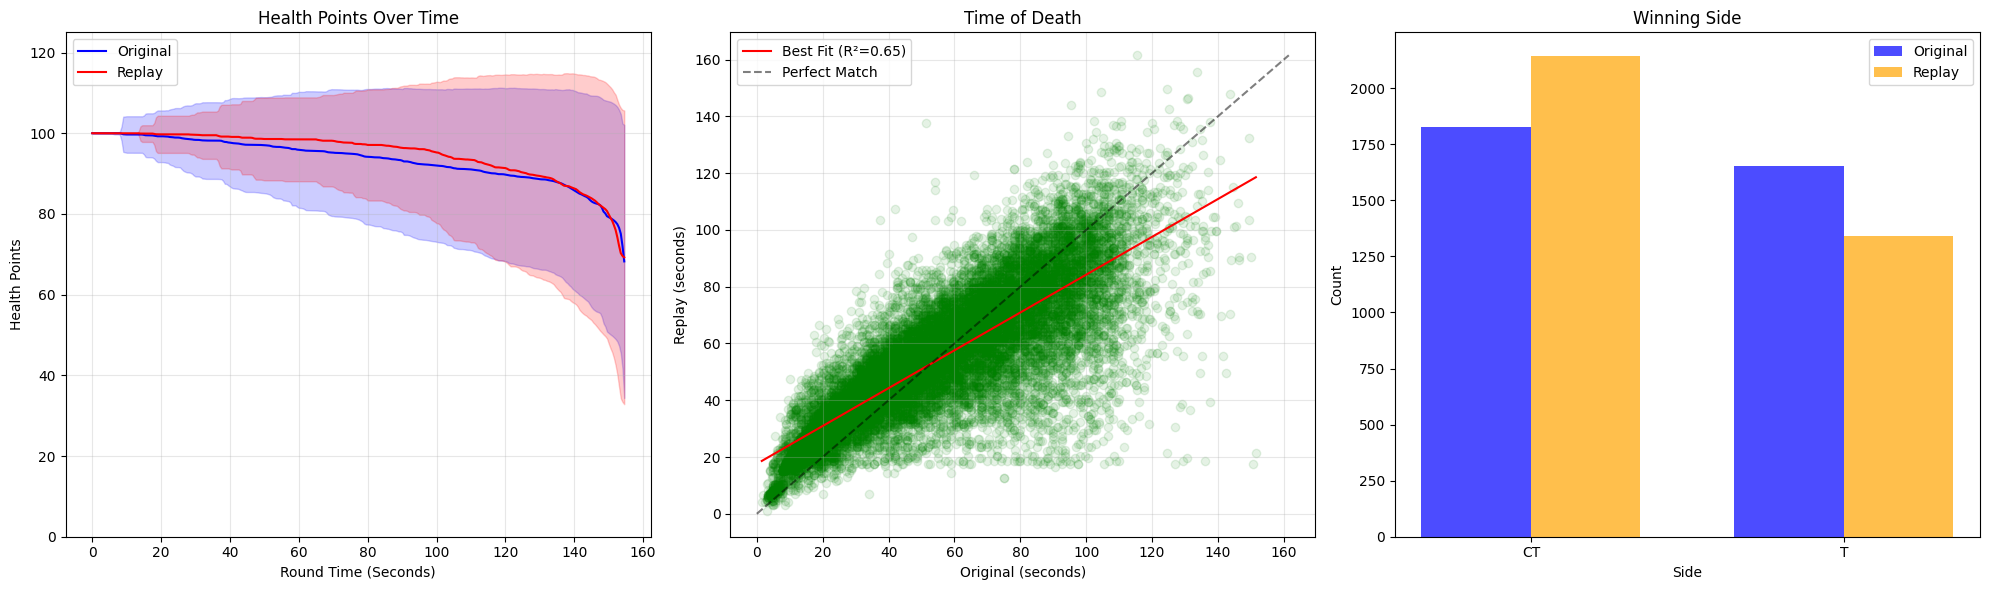

In [96]:
results = analyze_and_visualize_trajectories(player_trajectories, waypoint_trajectories, num_samples=500)

## **Metrics for Measuring Misalignment in Robot Trajectories**

### Procrustes Disparity


In [10]:
from evaluation import *
import seaborn as sns
import pandas as pd
from IPython.display import display
from tqdm import tqdm


ModuleNotFoundError: No module named 'fastdtw'

In [11]:
def aggregate_player_metrics(data: np.ndarray, metric_names: list):
    """
    Aggregates player metrics with mean, std, min, and max for each team and overall.
    
    Parameters:
    - data (np.ndarray): A (n, m) array where n = number of players (must be multiple of 10), m = number of metrics
    - metric_names (list): List of metric names corresponding to the columns in data
    
    Returns:
    - pd.DataFrame: Table with mean, std, min, and max for each team and overall
    """
    n, m = data.shape
    if n % 10 != 0:
        raise ValueError("Number of players (n) must be a multiple of 10")
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=metric_names)
    df["Team"] = [1 if i % 10 < 5 else 2 for i in range(n)]
    
    # T stats (Team 1)
    t_stats = df[df["Team"] == 1].drop(columns=["Team"]).agg(['mean', 'std', 'min', 'max']).T
    t_stats.columns = ['T_Mean', 'T_Std', 'T_Min', 'T_Max']
    
    # CT stats (Team 2)
    ct_stats = df[df["Team"] == 2].drop(columns=["Team"]).agg(['mean', 'std', 'min', 'max']).T
    ct_stats.columns = ['CT_Mean', 'CT_Std', 'CT_Min', 'CT_Max']
    
    # Overall stats
    overall_stats = df.drop(columns=["Team"]).agg(['mean', 'std', 'min', 'max']).T
    overall_stats.columns = ['Overall_Mean', 'Overall_Std', 'Overall_Min', 'Overall_Max']
    
    # Combine all stats
    final_stats = pd.concat([t_stats, ct_stats, overall_stats], axis=1)
    
    return final_stats

In [12]:
common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))

In [14]:
metrics = []
metric_column_names = []
metric_names = [
    "Procrustes",
    "Procrustes 2D",
    "DTW",
    "DTW 2D",
    "Euclidean",
    "Euclidean 2D",
    "RMSE",
    "RMSE 2D",
    "Frechet 2D"
]
metrics = [
    (procrustes_disparity, {'xy_only': False}),  
    (procrustes_disparity, {'xy_only': True}),  
    (dtw_distance_normalized, {'xy_only': False}),  
    (dtw_distance_normalized, {'xy_only': True}),  
    (euclidean_distance_normalized, {'xy_only': False}),
    (euclidean_distance_normalized, {'xy_only': True}),
    (rmse, {'xy_only': False}),
    (rmse, {'xy_only': True}),
    (frechet_distance, {'xy_only': True})
]

evaluation_results = []
common_traj_ids = list(set(player_trajectories.keys()) & set(waypoint_trajectories.keys()))
for traj_id in tqdm(common_traj_ids):
    player_trajectory = player_trajectories[traj_id]
    waypoint_trajectory = waypoint_trajectories[traj_id]

    player_traj = player_trajectory["player_trajectory"]
    waypoint_traj = waypoint_trajectory["player_trajectory"]
    player_traj_length = player_trajectory["player_seq_len"]
    waypoint_traj_length = waypoint_trajectory["player_seq_len"]

    for player_idx in range(10):
        player_traj_len = player_traj_length[player_idx]
        waypoint_traj_len = waypoint_traj_length[player_idx]
        player_traj_sample = player_traj[player_idx][:player_traj_len]
        waypoint_traj_sample = waypoint_traj[player_idx][:waypoint_traj_len]

        max_len = max(len(player_traj_sample), len(waypoint_traj_sample))
        player_traj_interp = interpolate_trajectory(player_traj_sample, max_len, method='linear')
        waypoint_traj_interp = interpolate_trajectory(waypoint_traj_sample, max_len, method='linear')

        evaluation_results_player = []
        for metric_fn, metric_fn_kwargs in metrics:
            score = metric_fn(player_traj_interp, waypoint_traj_interp, **metric_fn_kwargs)
            evaluation_results_player.append(score)
        evaluation_results.append(evaluation_results_player)

evaluation_results_np = np.array(evaluation_results)
evaluation_result_df = aggregate_player_metrics(evaluation_results_np, metric_names)



100%|██████████| 2261/2261 [34:37<00:00,  1.09it/s]


In [15]:
display(evaluation_result_df)

,T_Mean,T_Std,T_Min,T_Max,CT_Mean,CT_Std,CT_Min,CT_Max,Overall_Mean,Overall_Std,Overall_Min,Overall_Max
Procrustes,0.177101,0.158909,0.000988,0.986209,0.398041,0.261004,0.001238,0.999157,0.287571,0.242672,0.000988,0.999157
Procrustes 2D,0.176085,0.159299,0.000579,0.986559,0.399299,0.263694,0.001082,0.999735,0.287692,0.244765,0.000579,0.999735
DTW,1.193006,1.841844,0.448866,45.384106,1.689921,2.383891,0.320627,37.689303,1.441463,2.144574,0.320627,45.384106
DTW 2D,1.071425,1.836767,0.264743,45.349494,1.554350,2.366626,0.255817,37.562892,1.312888,2.132000,0.255817,45.349494
Euclidean,0.761301,0.345461,0.106444,3.640669,0.857894,0.428860,0.121321,4.229159,0.809597,0.392375,0.106444,4.229159
Euclidean 2D,0.756021,0.345871,0.078485,3.636764,0.851613,0.428471,0.113205,4.227353,0.803817,0.392282,0.078485,4.227353
RMSE,5.046778,2.793930,0.281625,29.847533,5.763661,3.102164,0.204051,28.402564,5.405219,2.973690,0.204051,29.847533
RMSE 2D,6.144265,3.422574,0.221990,36.543982,7.009282,3.794908,0.220982,34.769990,6.576774,3.639253,0.220982,36.543982
Frechet 2D,5.208499,8.372135,0.623731,74.864657,7.459741,10.110633,0.452046,81.282080,6.334120,9.349976,0.452046,81.282080


In [16]:
evaluation_result_df.to_csv("trajectory_metrics.csv")

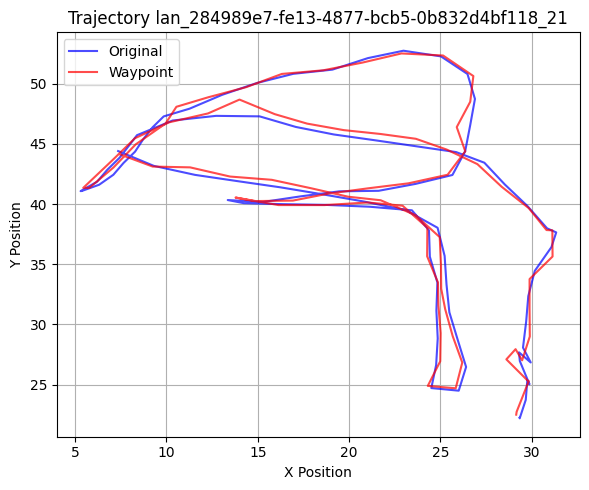

In [18]:
def plot_sample_trajectory(traj_id, selected_player_idx=None):
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Get the trajectories for the specified traj_id
    original = player_trajectories[traj_id]["player_trajectory"]
    waypoint = waypoint_trajectories[traj_id]["player_trajectory"]
    
    # Create dummy lines for legend
    dummy_orig, = ax.plot([], [], 'b-', alpha=0.7, label='Original')
    dummy_way, = ax.plot([], [], 'r-', alpha=0.7, label='Waypoint')
    ax.legend()
    
    # Plot trajectories for each player
    for player_idx in range(original.shape[0]):
        if selected_player_idx is not None and player_idx != selected_player_idx:
            continue
        # Get x and y coordinates for this player
        orig_x = original[player_idx, :, 0]  # x coordinate
        orig_y = original[player_idx, :, 1]  # y coordinate
        way_x = waypoint[player_idx, :, 0]   # x coordinate
        way_y = waypoint[player_idx, :, 1]   # y coordinate
        
        # Plot both trajectories
        ax.plot(orig_x, orig_y, 'b-', alpha=0.7)
        ax.plot(way_x, way_y, 'r-', alpha=0.7)
    
    ax.set_title(f'Trajectory {traj_id}')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Now you can call it with a specific trajectory ID
plot_sample_trajectory("lan_284989e7-fe13-4877-bcb5-0b832d4bf118_21", 9)  # or any specific traj_id you want to plot

In [15]:
for traj_id, player_idx, score in df.nlargest(10, 'disparity')[['traj_id', 'player_idx', 'disparity']].values:
    plot_sample_trajectory(traj_id, player_idx)
    print(score)


NameError: name 'df' is not defined

In [16]:
for traj_id, player_idx, score in df.nsmallest(10, 'disparity')[['traj_id', 'player_idx', 'disparity']].values:
    plot_sample_trajectory(traj_id, player_idx)
    print(score)

NameError: name 'df' is not defined

Processing trajectories...


100%|██████████| 5171/5171 [11:47<00:00,  7.31it/s]


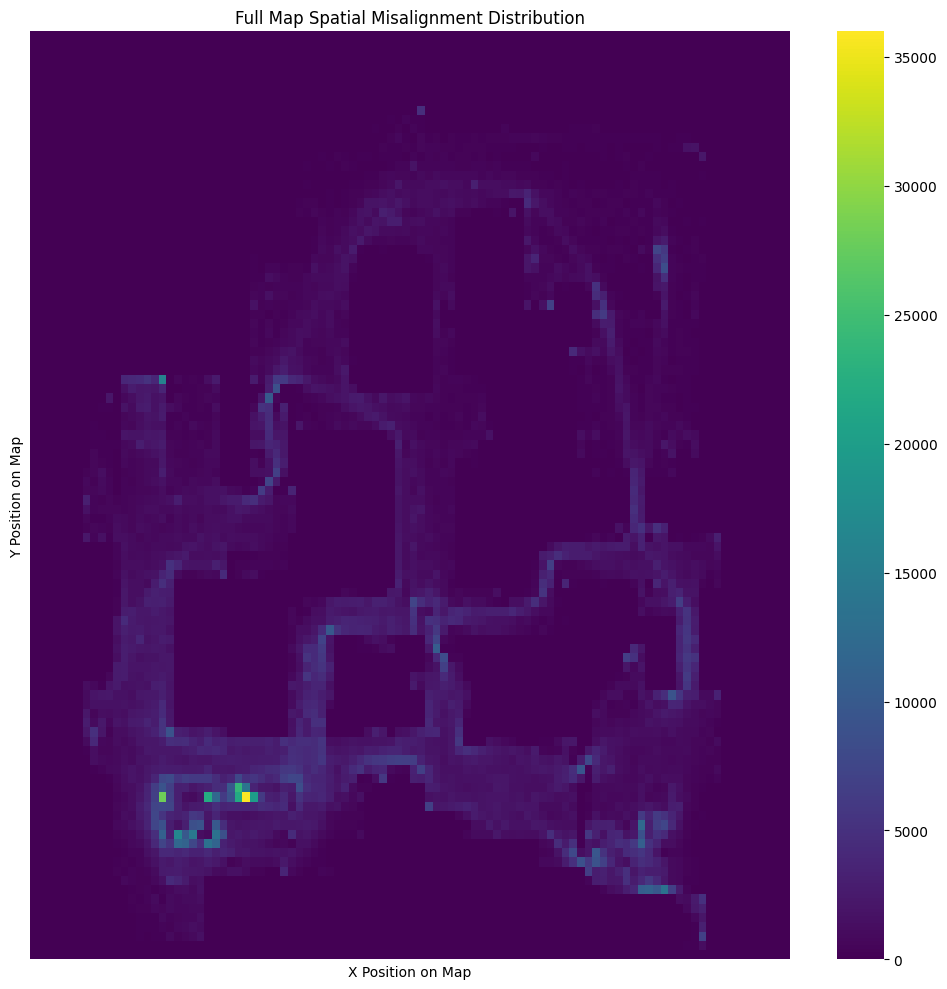

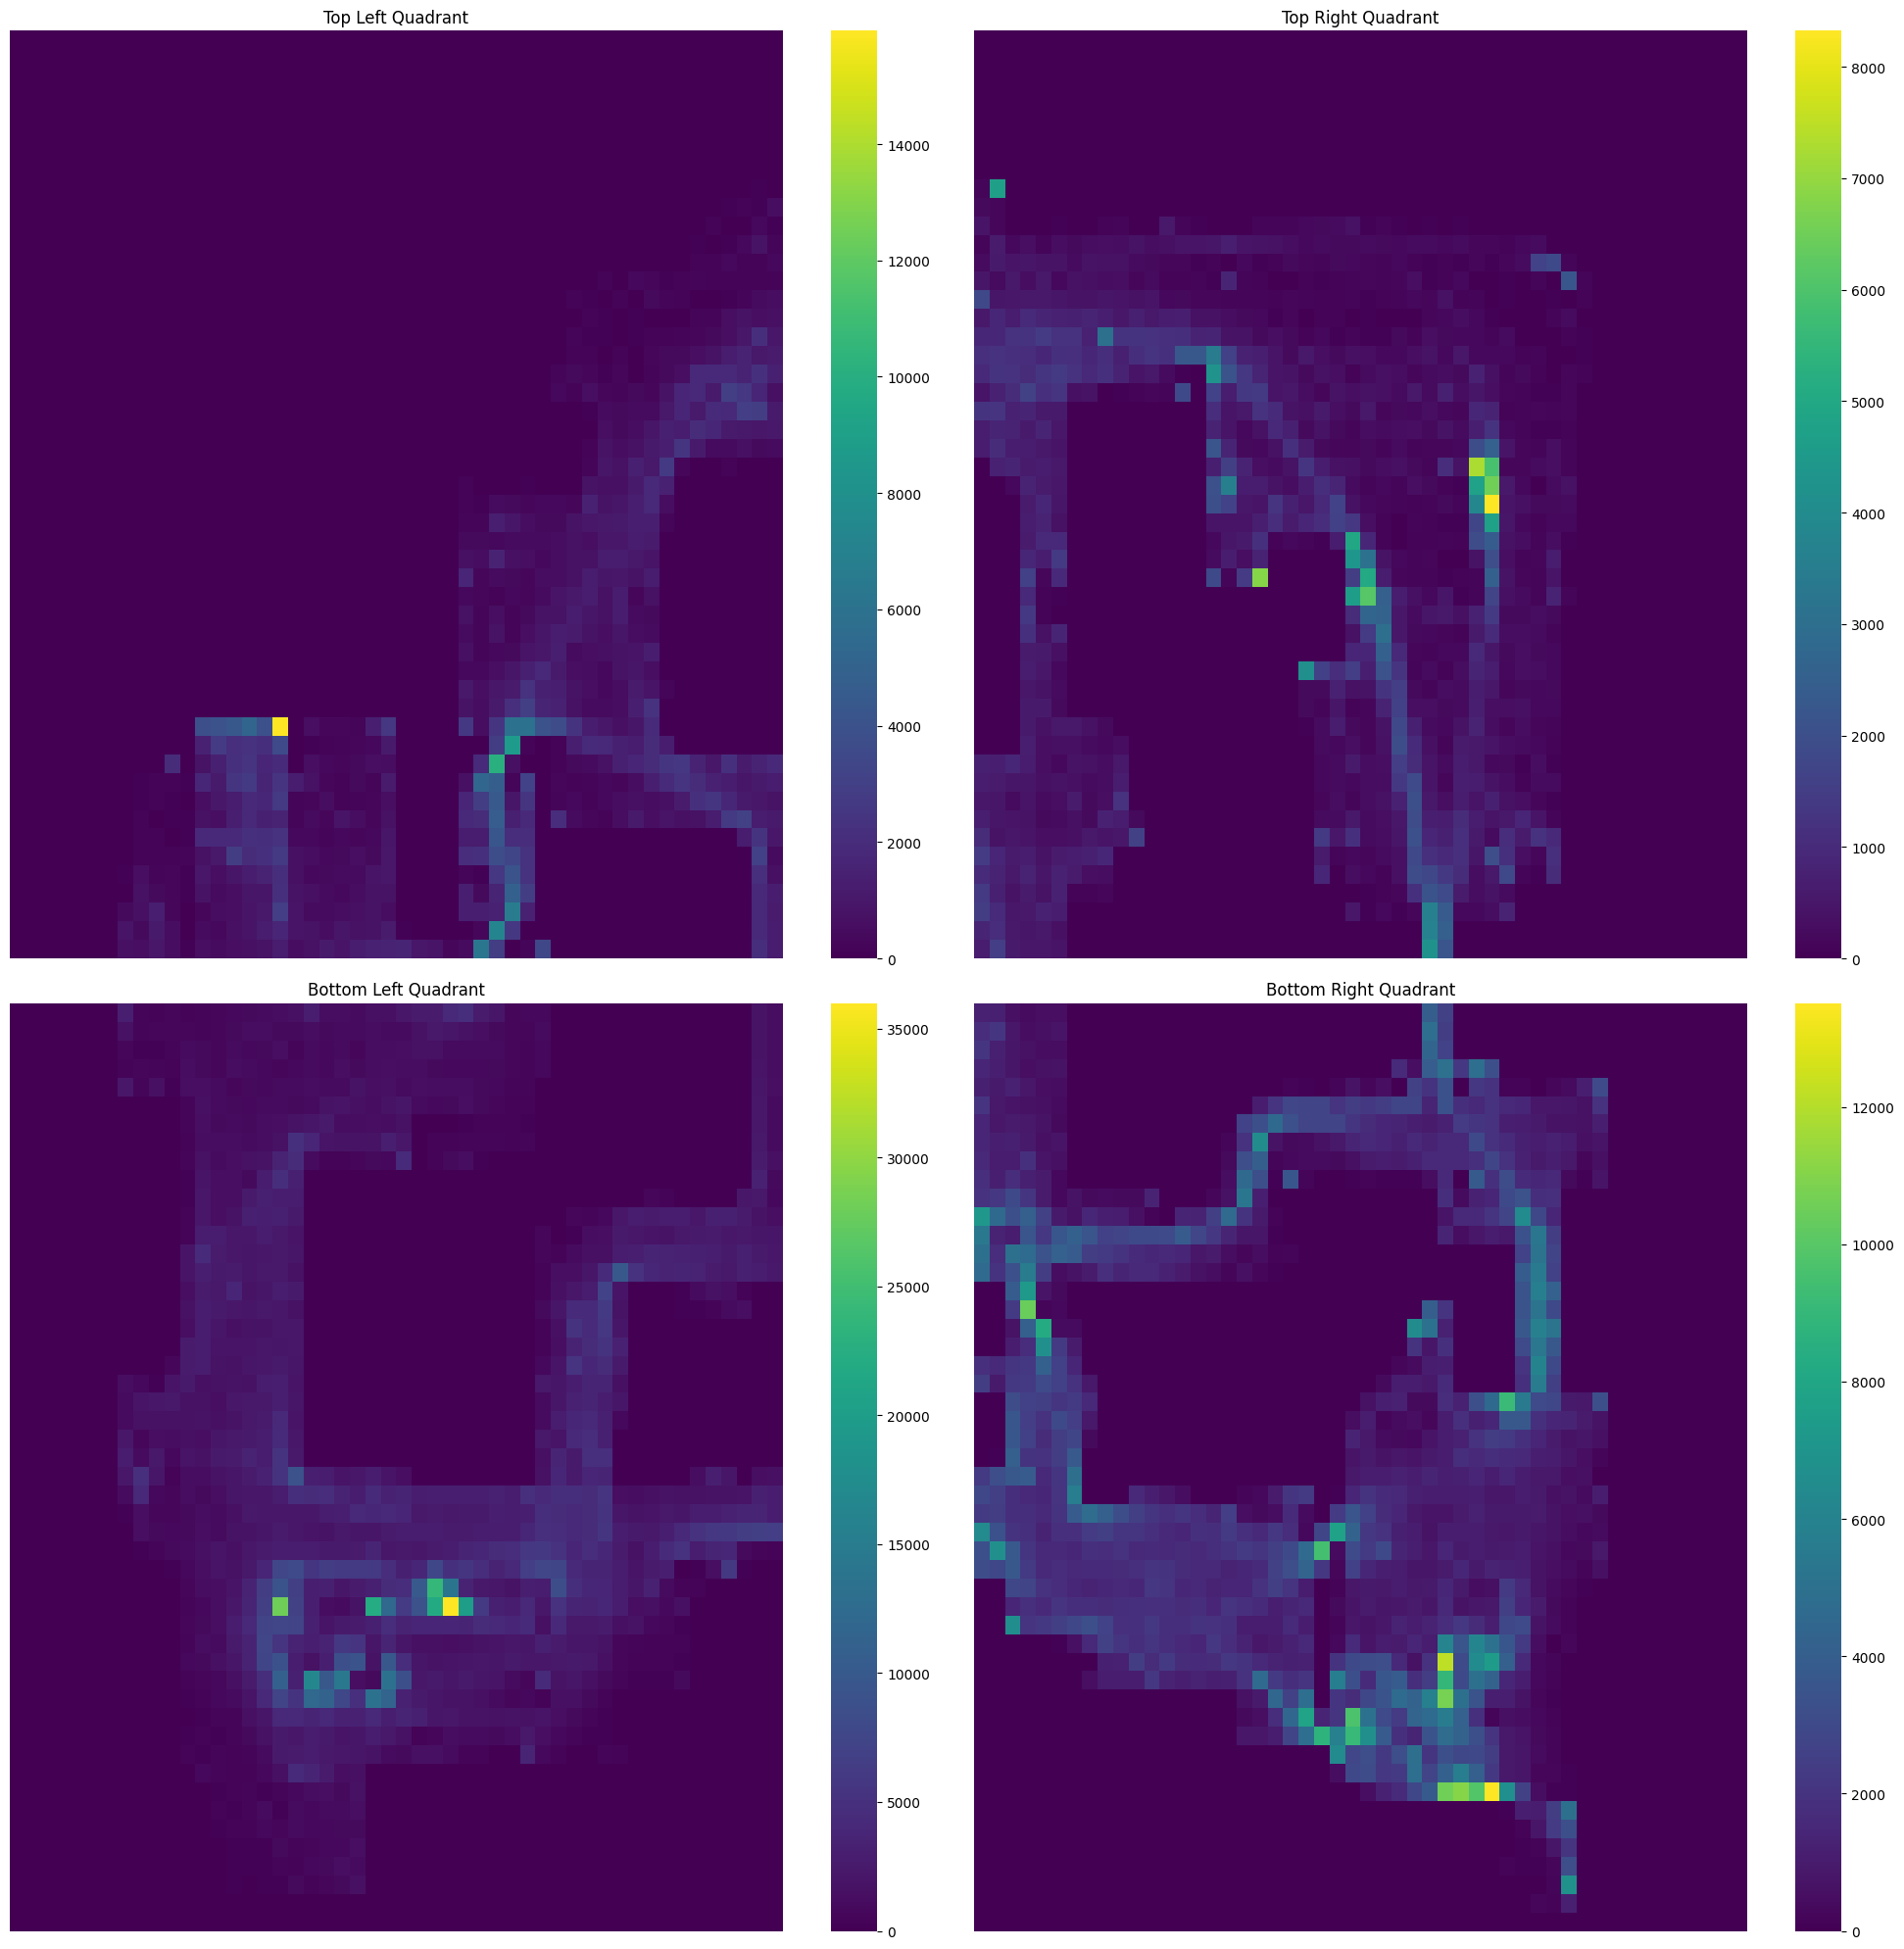

In [13]:
def collect_spatial_misalignment_data(player_trajectories, waypoint_trajectories, common_traj_ids):
    """
    Collects spatial misalignment data across all trajectories.
    
    Returns:
        np.ndarray: 100x100 heatmap array of spatial misalignments
    """
    # Storage for spatial heatmap
    spatial_heatmap = np.zeros((100, 100))
    
    # Define spatial bounds for heatmap
    x_bounds = (-50, 40)
    y_bounds = (-30, 60)
    
    print("Processing trajectories...")
    for traj_id in tqdm(common_traj_ids):
        for player_idx in range(10):
            # Get trajectories
            player_traj = player_trajectories[traj_id]["player_trajectory"][player_idx]
            waypoint_traj = waypoint_trajectories[traj_id]["player_trajectory"][player_idx]
            
            # Get actual sequence lengths
            player_len = player_trajectories[traj_id]["player_seq_len"][player_idx]
            waypoint_len = waypoint_trajectories[traj_id]["player_seq_len"][player_idx]
            
            # Trim to actual length
            player_traj = player_traj[:player_len]
            waypoint_traj = waypoint_traj[:waypoint_len]
            
            # Use only x,y coordinates
            player_traj = player_traj[:, :2]
            waypoint_traj = waypoint_traj[:, :2]
            
            # Calculate DTW
            distance, path = fastdtw(player_traj, waypoint_traj, dist=euclidean)
            path = np.array(path)
            
            # Calculate displacements for each aligned point
            displacements = np.array([euclidean(player_traj[i1], waypoint_traj[i2]) 
                                    for i1, i2 in path])
            
            # Update spatial heatmap
            for idx, (i1, i2) in enumerate(path):
                if displacements[idx] > np.percentile(displacements, 75):  # Focus on larger misalignments
                    # Convert positions to heatmap indices
                    x_idx = int((player_traj[i1, 0] - x_bounds[0]) / (x_bounds[1] - x_bounds[0]) * 99)
                    y_idx = int((player_traj[i1, 1] - y_bounds[0]) / (y_bounds[1] - y_bounds[0]) * 99)
                    x_idx = np.clip(x_idx, 0, 99)
                    y_idx = np.clip(y_idx, 0, 99)
                    spatial_heatmap[y_idx, x_idx] += displacements[idx]
    
    return spatial_heatmap

def plot_spatial_misalignment_with_quadrants(spatial_heatmap):
    """
    Creates two figures:
    1. Full map visualization
    2. Four quadrant visualizations
    
    Args:
        spatial_heatmap (np.ndarray): 100x100 array of spatial misalignments
    """
    # Figure 1: Full map
    plt.figure(figsize=(10, 10))
    sns.heatmap(spatial_heatmap[:, ::-1], cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title('Full Map Spatial Misalignment Distribution')
    plt.xlabel('X Position on Map')
    plt.ylabel('Y Position on Map')
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Quadrants
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
    
    # Split heatmap into quadrants
    mid_y, mid_x = spatial_heatmap.shape[0]//2, spatial_heatmap.shape[1]//2
    
    # Top Left
    sns.heatmap(spatial_heatmap[:mid_y, mid_x:][:, ::-1], cmap='viridis', ax=ax1, xticklabels=False, yticklabels=False)
    ax1.set_title('Top Left Quadrant')
    
    # Top Right
    sns.heatmap(spatial_heatmap[:mid_y, :mid_x][:, ::-1], cmap='viridis', ax=ax2, xticklabels=False, yticklabels=False)
    ax2.set_title('Top Right Quadrant')
    
    # Bottom Left
    sns.heatmap(spatial_heatmap[mid_y:, mid_x:][:, ::-1], cmap='viridis', ax=ax3, xticklabels=False, yticklabels=False)
    ax3.set_title('Bottom Left Quadrant')
    
    # Bottom Right
    sns.heatmap(spatial_heatmap[mid_y:, :mid_x][:, ::-1], cmap='viridis', ax=ax4, xticklabels=False, yticklabels=False)
    ax4.set_title('Bottom Right Quadrant')
    
    plt.tight_layout()
    plt.show()

# Usage:
spatial_heatmap = collect_spatial_misalignment_data(player_trajectories, waypoint_trajectories, common_traj_ids)
plot_spatial_misalignment_with_quadrants(spatial_heatmap)

Processing trajectories...


100%|██████████| 5171/5171 [08:46<00:00,  9.82it/s]


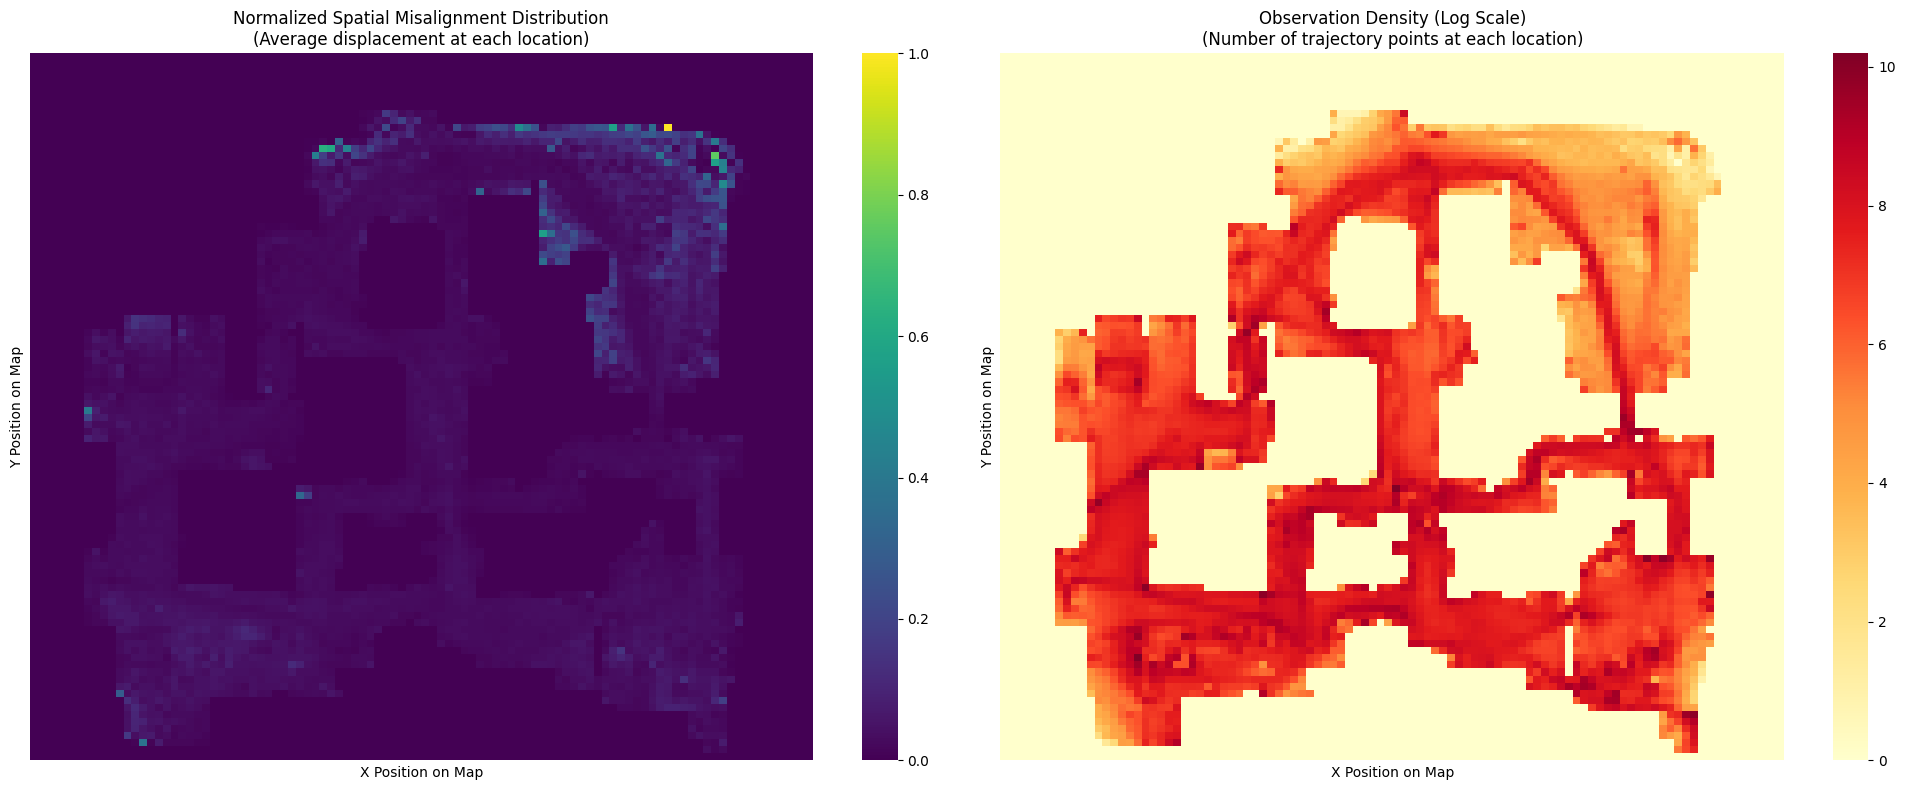

In [14]:
def collect_spatial_misalignment_data_normalized(player_trajectories, waypoint_trajectories, common_traj_ids):
    """
    Collects spatial misalignment data across all trajectories with normalization.
    Returns normalized average displacement at each location instead of cumulative values.
    
    Returns:
        np.ndarray: 100x100 heatmap array of normalized spatial misalignments
    """
    # Storage for spatial heatmap and count of observations
    spatial_heatmap = np.zeros((100, 100))
    observation_count = np.zeros((100, 100))
    
    # Define spatial bounds for heatmap
    x_bounds = (-50, 40)
    y_bounds = (-30, 60)
    
    print("Processing trajectories...")
    for traj_id in tqdm(common_traj_ids):
        for player_idx in range(10):
            # Get trajectories
            player_traj = player_trajectories[traj_id]["player_trajectory"][player_idx]
            waypoint_traj = waypoint_trajectories[traj_id]["player_trajectory"][player_idx]
            
            # Get actual sequence lengths
            player_len = player_trajectories[traj_id]["player_seq_len"][player_idx]
            waypoint_len = waypoint_trajectories[traj_id]["player_seq_len"][player_idx]
            
            # Trim to actual length
            player_traj = player_traj[:player_len]
            waypoint_traj = waypoint_traj[:waypoint_len]
            
            # Use only x,y coordinates
            player_traj = player_traj[:, :2]
            waypoint_traj = waypoint_traj[:, :2]
            
            # Calculate DTW
            distance, path = fastdtw(player_traj, waypoint_traj, dist=euclidean)
            path = np.array(path)
            
            # Calculate displacements for each aligned point
            displacements = np.array([euclidean(player_traj[i1], waypoint_traj[i2]) 
                                    for i1, i2 in path])
            
            # Update spatial heatmap
            for idx, (i1, i2) in enumerate(path):
                # Convert positions to heatmap indices
                x_idx = int((player_traj[i1, 0] - x_bounds[0]) / (x_bounds[1] - x_bounds[0]) * 99)
                y_idx = int((player_traj[i1, 1] - y_bounds[0]) / (y_bounds[1] - y_bounds[0]) * 99)
                x_idx = np.clip(x_idx, 0, 99)
                y_idx = np.clip(y_idx, 0, 99)
                
                # Add displacement value and increment counter
                spatial_heatmap[y_idx, x_idx] += displacements[idx]
                observation_count[y_idx, x_idx] += 1
    
    # Compute average displacement at each location
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    normalized_heatmap = spatial_heatmap / (observation_count + epsilon)
    
    # Further normalize to [0, 1] range
    if normalized_heatmap.max() > normalized_heatmap.min():
        normalized_heatmap = (normalized_heatmap - normalized_heatmap.min()) / (normalized_heatmap.max() - normalized_heatmap.min())
    
    return normalized_heatmap, observation_count

def plot_spatial_misalignment_normalized(normalized_heatmap, observation_count):
    """
    Creates visualizations for normalized spatial misalignment and observation density.
    
    Args:
        normalized_heatmap (np.ndarray): 100x100 array of normalized spatial misalignments
        observation_count (np.ndarray): 100x100 array of observation counts
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot normalized misalignment heatmap
    sns.heatmap(normalized_heatmap[:, ::-1], cmap='viridis', 
                ax=ax1, xticklabels=False, yticklabels=False)
    ax1.set_title('Normalized Spatial Misalignment Distribution\n(Average displacement at each location)')
    ax1.set_xlabel('X Position on Map')
    ax1.set_ylabel('Y Position on Map')
    
    # Plot observation density heatmap
    # Log scale for better visualization of observation counts
    log_counts = np.log1p(observation_count)  # log1p to handle zeros
    sns.heatmap(log_counts[:, ::-1], cmap='YlOrRd', 
                ax=ax2, xticklabels=False, yticklabels=False)
    ax2.set_title('Observation Density (Log Scale)\n(Number of trajectory points at each location)')
    ax2.set_xlabel('X Position on Map')
    ax2.set_ylabel('Y Position on Map')
    
    plt.tight_layout()
    plt.show()

# Usage:
normalized_heatmap, observation_count = collect_spatial_misalignment_data_normalized(
    player_trajectories, waypoint_trajectories, common_traj_ids)
plot_spatial_misalignment_normalized(normalized_heatmap, observation_count)

C:\Users\wangy\AppData\Local\Temp\ipykernel_2284\432269384.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\wangy\projects\pyMultiAgentFPS\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


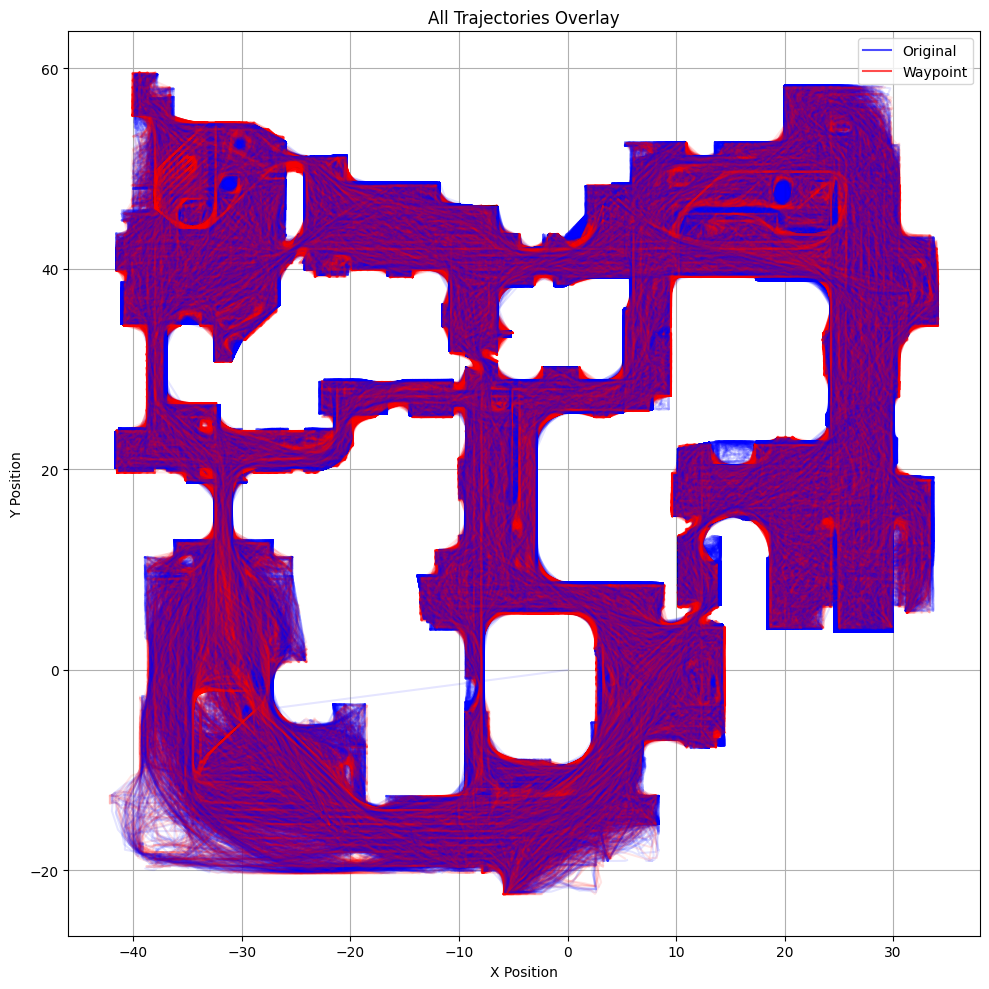

In [13]:
def plot_overlaid_trajectories(player_trajectories, waypoint_trajectories, alpha=0.1):
    """
    Creates a single plot with all trajectories overlaid.
    
    Args:
        player_trajectories (dict): Dictionary of original trajectories
        waypoint_trajectories (dict): Dictionary of waypoint trajectories
        alpha (float): Transparency level for each trajectory (default: 0.1)
    """
    plt.figure(figsize=(10, 10))
    
    # Create dummy lines for legend
    plt.plot([], [], 'b-', alpha=0.7, label='Original')
    plt.plot([], [], 'r-', alpha=0.7, label='Waypoint')
    
    # Plot all trajectories
    for traj_id in player_trajectories.keys():
        original = player_trajectories[traj_id]["player_trajectory"]
        waypoint = waypoint_trajectories[traj_id]["player_trajectory"]
        
        # Plot trajectories for each player
        for player_idx in range(original.shape[0]):
            # Get x and y coordinates for this player
            orig_x = original[player_idx, :, 0]  # x coordinate
            orig_y = original[player_idx, :, 1]  # y coordinate
            way_x = waypoint[player_idx, :, 0]   # x coordinate
            way_y = waypoint[player_idx, :, 1]   # y coordinate
            
            # Plot both trajectories
            plt.plot(orig_x, orig_y, 'b-', alpha=alpha)
            plt.plot(way_x, way_y, 'r-', alpha=alpha)
    
    plt.title('All Trajectories Overlay')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
plot_overlaid_trajectories(player_trajectories, waypoint_trajectories, alpha=0.1)